<a href="https://colab.research.google.com/github/poorvis885/Movie-Recommendation-System/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error


In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2024-12-20 11:12:50--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  6.05MB/s    in 0.2s    

2024-12-20 11:12:50 (6.05 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


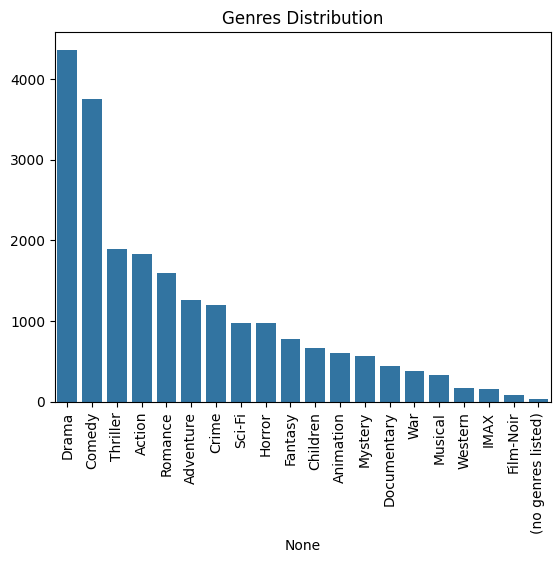

In [ ]:
# Checking basic info
print(movies.head())
print(ratings.head())

# Plot genre distribution
genres = movies['genres'].str.split('|', expand=True).stack().value_counts()
sns.barplot(x=genres.index, y=genres.values)
plt.xticks(rotation=90)
plt.title("Genres Distribution")
plt.show()


In [ ]:
# Creating user-item interaction matrix
user_movie_ratings = ratings.pivot_table(index='userId', columns='movieId', values='rating')

# Fill NaNs with 0s (indicating no rating)
user_movie_ratings.fillna(0, inplace=True)


In [ ]:
# Apply SVD for matrix factorization
svd = TruncatedSVD(n_components=50)  # Number of latent factors
svd_matrix = svd.fit_transform(user_movie_ratings)

# Reconstruct the user-item interaction matrix approximation
reconstructed_ratings = np.dot(svd_matrix, svd.components_)

# Convert it into a DataFrame
svd_df = pd.DataFrame(reconstructed_ratings, columns=user_movie_ratings.columns)


In [ ]:
def recommend_movies(user_id, num_recommendations=10):
    user_ratings = svd_df.iloc[user_id]
    unrated_movies = user_ratings[user_ratings == 0].index
    recommendations = svd_df[unrated_movies].iloc[user_id].sort_values(ascending=False).head(num_recommendations)
    return movies[movies['movieId'].isin(recommendations.index)]

# Example: Recommend top 10 movies for user 0
recommendations = recommend_movies(user_id=0, num_recommendations=10)
print(recommendations[['title']])


Empty DataFrame
Columns: [title]
Index: []


In [ ]:
# Vectorize the movie genres using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
movie_genres_matrix = tfidf.fit_transform(movies['genres'])

# Calculate the similarity matrix using cosine similarity
cosine_sim = cosine_similarity(movie_genres_matrix, movie_genres_matrix)


In [ ]:
def content_based_recommendations(movie_id, num_recommendations=10):
    # Get the index of the movie
    idx = movies[movies['movieId'] == movie_id].index[0]

    # Get the cosine similarity scores for the movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort movies based on similarity score (in descending order)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get indices of the top N most similar movies
    sim_scores = sim_scores[1:num_recommendations+1]
    movie_indices = [i[0] for i in sim_scores]

    return movies.iloc[movie_indices]

# Example: Get content-based recommendations for movie with movieId 1
recommendations_content = content_based_recommendations(movie_id=1, num_recommendations=10)
print(recommendations_content[['title']])


                                                  title
1706                                        Antz (1998)
2355                                 Toy Story 2 (1999)
2809     Adventures of Rocky and Bullwinkle, The (2000)
3000                   Emperor's New Groove, The (2000)
3568                              Monsters, Inc. (2001)
6194                                   Wild, The (2006)
6486                             Shrek the Third (2007)
6948                     Tale of Despereaux, The (2008)
7760  Asterix and the Vikings (Astérix et les Viking...
8219                                       Turbo (2013)


In [ ]:
# Evaluate collaborative filtering model using RMSE
actual_ratings = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
predicted_ratings = np.dot(svd_matrix, svd.components_)
rmse = np.sqrt(mean_squared_error(actual_ratings.values, predicted_ratings))
print(f"RMSE: {rmse}")


RMSE: 0.30658197193759784


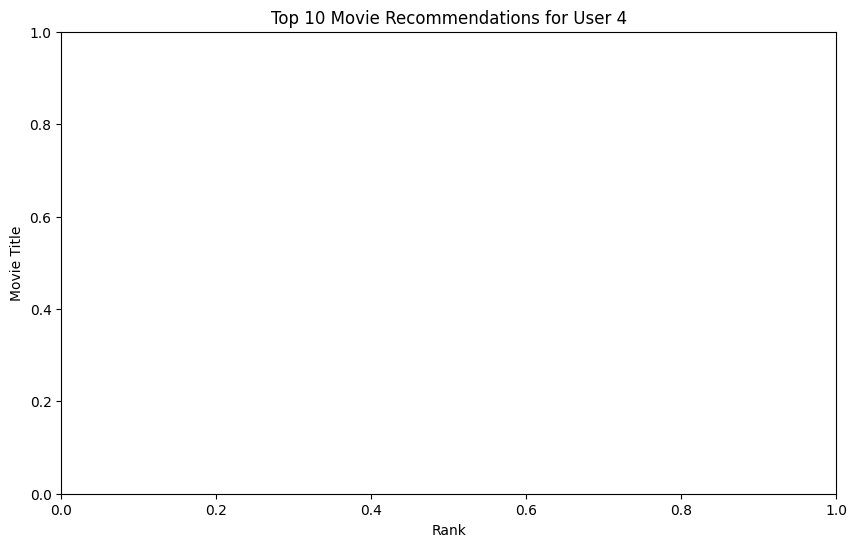

In [ ]:
# Visualize the top N recommended movies for a specific user
recommended_movies = recommend_movies(user_id=0, num_recommendations=10)

# Add a new column for ranking (or use scores from the recommendations)
recommended_movies['rank'] = np.arange(1, len(recommended_movies) + 1)

# Plot using sns.barplot() with the rank on the x-axis and titles on the y-axis
plt.figure(figsize=(10, 6))
sns.barplot(x=recommended_movies['rank'], y=recommended_movies['title'], palette='viridis')
plt.title("Top 10 Movie Recommendations for User 0")
plt.xlabel("Rank")
plt.ylabel("Movie Title")
plt.show()


In [ ]:
# Function to recommend movies based on collaborative filtering (SVD)
def recommend_movies(user_id, num_recommendations=10):
    user_ratings = svd_df.iloc[user_id]
    unrated_movies = user_ratings[user_ratings == 0].index
    recommendations = svd_df[unrated_movies].iloc[user_id].sort_values(ascending=False).head(num_recommendations)

    # Return movie details for recommended movies
    recommended_movie_ids = recommendations.index
    recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]

    # Add the ranking to the dataframe
    recommended_movies['rank'] = np.arange(1, len(recommended_movies) + 1)

    return recommended_movies[['rank', 'title']]

# Example: Get recommendations for user 0
recommended_movies = recommend_movies(user_id=0, num_recommendations=10)
print(recommended_movies)  # To check if the recommendations are generated correctly


Empty DataFrame
Columns: [rank, title]
Index: []


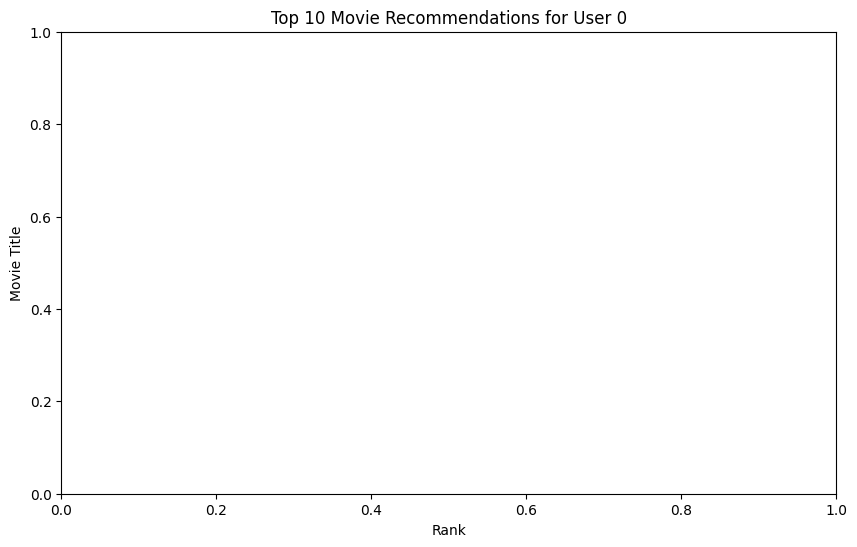

In [ ]:
# Visualize the top N recommended movies for user 0
plt.figure(figsize=(10, 6))
sns.barplot(x=recommended_movies['rank'], y=recommended_movies['title'], palette='viridis')

# Set titles and labels for clarity
plt.title("Top 10 Movie Recommendations for User 0")
plt.xlabel("Rank")
plt.ylabel("Movie Title")

# Show the plot
plt.show()


In [ ]:
print(recommended_movies)


Empty DataFrame
Columns: [rank, title]
Index: []


In [ ]:
# Save recommendations to CSV
recommended_movies.to_csv('recommended_movies.csv', index=False)
